# **04** Modeling / Feature Selection

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split

import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.vector_ar.vecm import VAR
# from statsmodels.tsa.vector_ar.vecm import coint_johansen
# from statsmodels.tsa.stattools import adfuller
# from statsmodels.tsa.seasonal import seasonal_decompose

# from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [22]:
# Import datasets
train = pd.read_csv('./data/model/rtm_train_updated.csv')
unseen = pd.read_csv('./data/model/rtm_test_updated.csv')

# Recreate DateTimeIndex for Training & Unseen Dataset
train.index = pd.to_datetime(train['year-month'])
train = train.drop(columns='year-month')

unseen.index = pd.to_datetime(unseen['year-month'])
unseen = unseen.drop(columns='year-month')

In [23]:
# Which dataset would you like to look at
dataset = train

# Which dataseries in the dataset would you like to look at
dataseries = 'passengers'

# Let's recall the top 10 routes by passengers
dataset.groupby('route')[[dataseries]].mean().sort_values(by=dataseries, ascending=False).head(10)

,passengers
route,
"Dallas, TX - Houston, TX",150724.542373
"Chicago, IL - Los Angeles, CA",124848.338983
"Las Vegas, NV - Los Angeles, CA",124131.974576
"Atlanta, GA - Orlando, FL",110970.000000
"Chicago, IL - New York, NY",109807.771186
"Atlanta, GA - Dallas, TX",101103.226891
"Atlanta, GA - Washington, DC",100710.033898
"Atlanta, GA - Chicago, IL",99904.533898
"Atlanta, GA - New York, NY",99660.779661


# Modeling
- Setting our itinerary to our route we will model 
- Let's look at the numbers from other perspectives
    - Routes that fall into 100 mile increments by distance (i.e. 0-100, 100-200, etc.)
    - Routes by departing airport
    - Routes by Latitude & Longitude

In [24]:
# Let's set the itinerary we will be analyzing
itinerary = 'Atlanta, GA - Columbus, OH'

# Let's look Save a Mask for the dataset for train & unseen datasets
route = train[train['route'] == itinerary].copy()
unseen_route = unseen[unseen['route'] == itinerary].copy()

In [25]:
# Let's look at our possible features
feature_options = sorted(list(train.columns))
feature_options

['airfare',
 'airfare_lag_1',
 'cost_per_mile',
 'dest_lat',
 'dest_long',
 'dist_miles',
 'flight_demand',
 'flight_demand_lag_1',
 'flight_demand_lag_12',
 'flight_revenue',
 'flight_revenue_lag_12',
 'fuel_usd_pergallon',
 'fuel_usd_pergallon_lag_1',
 'num_of_flights',
 'num_of_flights_lag_12',
 'num_of_flights_lag_2',
 'num_of_flights_lag_3',
 'origin_lat',
 'origin_long',
 'passengers',
 'passengers_lag_1',
 'passengers_lag_12',
 'passengers_per_flight',
 'passengers_per_flight_lag_1',
 'passengers_per_flight_lag_12',
 'pop_dest',
 'pop_origin',
 'route',
 'seat_capacity',
 'seat_capacity_lag_1',
 'seat_capacity_lag_2',
 'sf_airfare_diff_1',
 'sf_airfare_diff_2',
 'sf_airfare_lag_1_diff_1',
 'sf_airfare_lag_1_diff_2',
 'sf_cost_per_mile_diff_1',
 'sf_cost_per_mile_diff_2',
 'sf_flight_demand_diff_1',
 'sf_flight_demand_diff_2',
 'sf_flight_demand_lag_12_diff_1',
 'sf_flight_demand_lag_12_diff_2',
 'sf_flight_demand_lag_1_diff_1',
 'sf_flight_demand_lag_1_diff_2',
 'sf_flight_reven

In [26]:
# We created a lot of features within our 03 jupyter notebook.  let's separate them to ensure we model with correct ones
# Any feature that was differenced was done so for a reason.  Any original column that was differenced should not be used in model.

differenced_features = []
other_features = []
for feature in feature_options:
    if 'diff' in feature:
        differenced_features.append(feature)
    else:
        other_features.append(feature)

In [27]:
other_features # we will only keep # 'dist_miles' as the rest of the features have been differenced or...
               # we won't be using as of now -- but will later, i.e. dest lat, dest long, origin lat, origin long
               # we won't be using any population data as of now or later (dest pop, origin pop)

# save over other features per now....we may come back later and alter       
other_features = ['dist_miles']

# combine features into one list
final_features = differenced_features + other_features
final_features

['sf_airfare_diff_1',
 'sf_airfare_diff_2',
 'sf_airfare_lag_1_diff_1',
 'sf_airfare_lag_1_diff_2',
 'sf_cost_per_mile_diff_1',
 'sf_cost_per_mile_diff_2',
 'sf_flight_demand_diff_1',
 'sf_flight_demand_diff_2',
 'sf_flight_demand_lag_12_diff_1',
 'sf_flight_demand_lag_12_diff_2',
 'sf_flight_demand_lag_1_diff_1',
 'sf_flight_demand_lag_1_diff_2',
 'sf_flight_revenue_diff_1',
 'sf_flight_revenue_diff_2',
 'sf_flight_revenue_lag_12_diff_1',
 'sf_flight_revenue_lag_12_diff_2',
 'sf_fuel_usd_pergallon_diff_1',
 'sf_fuel_usd_pergallon_lag_1_diff_1',
 'sf_num_of_flights_diff_1',
 'sf_num_of_flights_diff_2',
 'sf_num_of_flights_lag_12_diff_1',
 'sf_num_of_flights_lag_12_diff_2',
 'sf_num_of_flights_lag_2_diff_1',
 'sf_num_of_flights_lag_2_diff_2',
 'sf_num_of_flights_lag_3_diff_1',
 'sf_num_of_flights_lag_3_diff_2',
 'sf_passengers_diff_1',
 'sf_passengers_diff_2',
 'sf_passengers_lag_12_diff_1',
 'sf_passengers_lag_12_diff_2',
 'sf_passengers_lag_1_diff_1',
 'sf_passengers_lag_1_diff_2',
 '

In [28]:
sorted(list(train.columns))

['airfare',
 'airfare_lag_1',
 'cost_per_mile',
 'dest_lat',
 'dest_long',
 'dist_miles',
 'flight_demand',
 'flight_demand_lag_1',
 'flight_demand_lag_12',
 'flight_revenue',
 'flight_revenue_lag_12',
 'fuel_usd_pergallon',
 'fuel_usd_pergallon_lag_1',
 'num_of_flights',
 'num_of_flights_lag_12',
 'num_of_flights_lag_2',
 'num_of_flights_lag_3',
 'origin_lat',
 'origin_long',
 'passengers',
 'passengers_lag_1',
 'passengers_lag_12',
 'passengers_per_flight',
 'passengers_per_flight_lag_1',
 'passengers_per_flight_lag_12',
 'pop_dest',
 'pop_origin',
 'route',
 'seat_capacity',
 'seat_capacity_lag_1',
 'seat_capacity_lag_2',
 'sf_airfare_diff_1',
 'sf_airfare_diff_2',
 'sf_airfare_lag_1_diff_1',
 'sf_airfare_lag_1_diff_2',
 'sf_cost_per_mile_diff_1',
 'sf_cost_per_mile_diff_2',
 'sf_flight_demand_diff_1',
 'sf_flight_demand_diff_2',
 'sf_flight_demand_lag_12_diff_1',
 'sf_flight_demand_lag_12_diff_2',
 'sf_flight_demand_lag_1_diff_1',
 'sf_flight_demand_lag_1_diff_2',
 'sf_flight_reven

In [32]:
# copy & past final features here for easy removal
final_features = [
#  'airfare',
#  'airfare_lag_1',
#  'cost_per_mile',
#  'dest_lat',
#  'dest_long',
#  'dist_miles',
#  'flight_demand',
#  'flight_demand_lag_1',
#  'flight_demand_lag_12',
#  'flight_revenue',
#  'flight_revenue_lag_12',
#  'fuel_usd_pergallon',
#  'fuel_usd_pergallon_lag_1',
#  'num_of_flights',
#  'num_of_flights_lag_12',
#  'num_of_flights_lag_2',
#  'num_of_flights_lag_3',
#  'origin_lat',
#  'origin_long',
#  'passengers',
#  'passengers_lag_1',
#  'passengers_lag_12',
#  'passengers_per_flight',
#  'passengers_per_flight_lag_1',
#  'passengers_per_flight_lag_12',
#  'pop_dest',
#  'pop_origin',
#  'route',
#  'seat_capacity',
#  'seat_capacity_lag_1',
#  'seat_capacity_lag_2',
#  'sf_airfare_diff_1',
#  'sf_airfare_diff_2',
#  'sf_airfare_lag_1_diff_1',
#  'sf_airfare_lag_1_diff_2',
#  'sf_cost_per_mile_diff_1',
#  'sf_cost_per_mile_diff_2',
#  'sf_flight_demand_diff_1',
#  'sf_flight_demand_diff_2',
#  'sf_flight_demand_lag_12_diff_1',
#  'sf_flight_demand_lag_12_diff_2',
#  'sf_flight_demand_lag_1_diff_1',
#  'sf_flight_demand_lag_1_diff_2',
#  'sf_flight_revenue_diff_1',
#  'sf_flight_revenue_diff_2',
#  'sf_flight_revenue_lag_12_diff_1',
#  'sf_flight_revenue_lag_12_diff_2',
#  'sf_fuel_usd_pergallon_diff_1',
#  'sf_fuel_usd_pergallon_lag_1_diff_1',
#  'sf_num_of_flights_diff_1',
#  'sf_num_of_flights_diff_2',
#  'sf_num_of_flights_lag_12_diff_1',
#  'sf_num_of_flights_lag_12_diff_2',
#  'sf_num_of_flights_lag_2_diff_1',
#  'sf_num_of_flights_lag_2_diff_2',
#  'sf_num_of_flights_lag_3_diff_1',
#  'sf_num_of_flights_lag_3_diff_2',
#  'sf_passengers_diff_1',
#  'sf_passengers_diff_2',
#  'sf_passengers_lag_12_diff_1',
#  'sf_passengers_lag_12_diff_2',
#  'sf_passengers_lag_1_diff_1',
#  'sf_passengers_lag_1_diff_2',
#  'sf_passengers_per_flight_diff_1',
#  'sf_passengers_per_flight_diff_2',
#  'sf_passengers_per_flight_lag_12_diff_1',
#  'sf_passengers_per_flight_lag_12_diff_2',
#  'sf_passengers_per_flight_lag_1_diff_1',
#  'sf_passengers_per_flight_lag_1_diff_2',
#  'sf_seat_capacity_diff_1',
#  'sf_seat_capacity_diff_2',
#  'sf_seat_capacity_lag_1_diff_1',
#  'sf_seat_capacity_lag_1_diff_2',
#  'sf_seat_capacity_lag_2_diff_1',
#  'sf_seat_capacity_lag_2_diff_2',
#  'sf_time_diff_1',
#  'sf_total_flight_cost_diff_1',
#  'sf_total_flight_cost_diff_2',
#  'sf_total_flight_miles_diff_1',
#  'sf_total_flight_miles_diff_2',
#  'time',
#  'total_flight_cost',
#  'total_flight_miles'


# the older ish   
 'sf_airfare_diff_1',
 'sf_airfare_lag_1_diff_1',
 'sf_cost_per_mile_diff_1',
 'sf_flight_demand_diff_1',
 'sf_flight_demand_lag_12_diff_1',
 'sf_flight_demand_lag_1_diff_1',
 'sf_flight_revenue_diff_2',
 'sf_flight_revenue_lag_12_diff_1',
 'sf_fuel_usd_pergallon_diff_1', ###########
 'sf_fuel_usd_pergallon_lag_1_diff_1', ###########
 'sf_num_of_flights_diff_1',
 'sf_num_of_flights_lag_12_diff_1',
 'sf_num_of_flights_lag_2_diff_1',
 'sf_num_of_flights_lag_3_diff_1',
 'sf_passengers_diff_2',
 'sf_passengers_lag_12_diff_2',
 'sf_passengers_lag_1_diff_2',
 'sf_passengers_per_flight_diff_2',
 'sf_passengers_per_flight_lag_12_diff_2', ###########
 'sf_passengers_per_flight_lag_1_diff_1',
 'sf_seat_capacity_diff_1',
 'sf_seat_capacity_lag_1_diff_1',
 'sf_seat_capacity_lag_2_diff_1',
 'sf_total_flight_cost_diff_2',
 'sf_total_flight_miles_diff_1',
 'dist_miles'

]

# Notice all columns used our DIFF except dist miles which was never differenced

# MAKING NOTE THAT THESE FEATURES ARE GIVING ME NEAR PERFECT RESULTS -- ['sf_airfare_diff_1', 'sf_cost_per_mile_diff_1', 'sf_fuel_usd_pergallon_diff_1', 'sf_fuel_usd_pergallon_lag_1_diff_1', 'sf_num_of_flights_lag_2_diff_1', 'sf_passengers_lag_1_diff_2', 'sf_passengers_per_flight_lag_12_diff_2', 'dist_miles']

### Modeling / Visualization / Analysis Function
- The function below takes in the training dataset & the unseen dataset as well as routes
- It will visualize the results of our model for the test dataset as well as predictions on unseen data
- Additionally it will show us R2, RMSE, and MSE data to compare model/results

In [33]:
def model_func(df_train,
               df_unseen,
               itinerary='Dallas, TX - Houston, TX',
               target_variable_string='airfare', 
               features=final_features,):

#     ['sf_airfare_diff_1', 'sf_cost_per_mile_diff_1', 'sf_fuel_usd_pergallon_diff_1','sf_fuel_usd_pergallon_lag_1_diff_1', 
#                          'sf_num_of_flights_lag_2_diff_1', 'sf_passengers_lag_1_diff_2', 'sf_passengers_per_flight_lag_12_diff_2', 'dist_miles']
    
    
# BOTH    
    # save routes in training & unseen data
    df_train = df_train[df_train['route'] == itinerary].copy()
    df_unseen = df_unseen[df_unseen['route'] == itinerary].copy()

# TRAIN
    # Set X & y variables
    X = df_train[features]
    y = df_train[target_variable_string]
    
    # Train / Test / Split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, shuffle=False)
    
    # Add CONSTANT since we are using statsmodel
    X_train = sm.add_constant(X_train, has_constant='add')
    X_test = sm.add_constant(X_test, has_constant='add')

    # Drop NA values -- statsmodel can't handle
    X_train.dropna(inplace=True)

    # Subset y to match the index from X
    y_train = y_train[X_train.index]

    # Instantiate & fit model
    linear_model = sm.OLS(y_train, X_train).fit()
    
    print(itinerary)
    print()
    print(linear_model.summary())
    
    # Generate predictions
    y_train_pred = linear_model.predict(X_train)
    y_test_pred = linear_model.predict(X_test)

    # Baseline Series
    y_test_baseline = [y_test.mean()] * len(y_test)
    
    # Scoring
    train_r2 = r2_score(y_train, y_train_pred)
    train_rmse = mean_squared_error(y_train, y_train_pred, squared=False)
    train_mse = mean_squared_error(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)
    test_rmse = mean_squared_error(y_test, y_test_pred, squared=False)
    test_mse = mean_squared_error(y_test, y_test_pred)
    base_r2 = r2_score(y_test, y_test_baseline)
    base_rmse = mean_squared_error(y_test, y_test_baseline, squared=False)
    base_mse = mean_squared_error(y_test, y_test_baseline)
    

    # Print Scoring
    print('-------------------------')
    print('Train Analytics')
    print('-------------------------')
    print(f'     TRAIN R2: {train_r2}')
    print(f'   TRAIN RMSE: {train_rmse}')
#     print(f'    TRAIN MSE: {train_mse}')
    print('-------------------------')
    print('Test Analytics')
    print('-------------------------')
    print(f'      TEST R2: {test_r2}')
    print(f'    TEST RMSE: {test_rmse}')
#     print(f'     TEST MSE: {test_mse}')
    print('-------------------------')
    print('Baseline Analytics')
    print('-------------------------')
    print(f'  Baseline R2: {base_r2}')
    print(f'Baseline RMSE: {base_rmse}')
#     print(f' Baseline MSE: {base_mse}')
    print()
    
    # Plot Train/Test & Model Predictions on Training Dataset

    # Set figure size.
    plt.figure(figsize=(12, 4))
    plt.grid()
    
    # Plot training data.
    plt.plot(y_train.index, y_train.values, color = 'blue', label='Training Values')
    # Plot testing data.
    plt.plot(y_test.index, y_test.values, color = 'orange', label='Test Values', linewidth=10)
    # Plot predicted test values.
    plt.plot(y_test_pred, color = 'green', label='Predicted Test Values')

    # Set label.
    plt.title(label = 'Train / Test + Predictions: ' + str(itinerary), fontsize=20)
    # Resize tick marks.
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12);
    # Label Axis
    plt.ylabel('Airfare Ticket Price ($ USD)', size=12)
    plt.xlabel('Year-Month', size=12)
    # add legend
    plt.legend();

# UNSEEN

    # Create X variable for our unseen dataset with the matching itinerary of our model
    X_unseen = df_unseen[features]

    # Add X Constant
    X_unseen = sm.add_constant(X_unseen, has_constant='add')

    # Make Predictions -- In this case we are predicting airfare price
    unseen_pred = linear_model.predict(X_unseen)

    # save predictions to unseen route df
    df_unseen['airfare_predictions'] = unseen_pred

    # dropna values for scoring
    df_unseen = df_unseen.dropna()
    
    # score
    unseen_r2 = r2_score(df_unseen.airfare, df_unseen.airfare_predictions)
    unseen_rmse = mean_squared_error(df_unseen.airfare, df_unseen.airfare_predictions, squared=False)
    unseen_mse = mean_squared_error(df_unseen.airfare, df_unseen.airfare_predictions, squared=True)
    
    # print score
    print('-------------------------------------------')
    print('Analytics for Predictions on unseen Data')
    print('-------------------------------------------')
    print(f'      PRED R2: {unseen_r2}')
    print(f'    PRED RMSE: {unseen_rmse}')
#     print(f'     PRED MSE: {unseen_mse}')

    # Let's plot our predictions! 

    # Set figure size.
    plt.figure(figsize=(12, 4))
    plt.grid()

    # Plot actual data.
    plt.plot(df_unseen['airfare'], color = 'orange', label='Actual Airfare Price', linewidth=10)

    # Plot predicted test values.
    plt.plot(df_unseen['airfare_predictions'], color = 'green', label='Predicted Airfare Price')

    # Set label.
    plt.title(label = 'Predictions (unseen data): ' + str(itinerary), fontsize=20)

    # Resize tick marks.
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12);

    # Label Axis
    plt.ylabel('Airfare Ticket Price ($ USD)', size=12)
    plt.xlabel('Year-Month', size=12)

    # add legend
    plt.legend();
    
    # create datafram with the analytics for the route
    results_df = pd.DataFrame(data=[[itinerary, base_r2, train_r2, test_r2, unseen_r2, base_rmse, train_rmse, test_rmse, unseen_rmse]],
                              columns=['route', 'base_r2', 'train_r2', 'test_r2', 'unseen_r2', 'base_rmse', 'train_rmse', 'test_rmse', 'unseen_rmse'])
    
    # linear_model returns the model object, results_df returns the invidual route analytics
    return linear_model, results_df 

Dallas, TX - Houston, TX

                            OLS Regression Results                            
Dep. Variable:                airfare   R-squared:                       0.393
Model:                            OLS   Adj. R-squared:                  0.107
Method:                 Least Squares   F-statistic:                     1.372
Date:                Wed, 07 Oct 2020   Prob (F-statistic):              0.161
Time:                        20:55:02   Log-Likelihood:                -233.75
No. Observations:                  82   AIC:                             521.5
Df Residuals:                      55   BIC:                             586.5
Df Model:                          26                                         
Covariance Type:            nonrobust                                         
                                             coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------

ValueError: Found array with 0 sample(s) (shape=(0,)) while a minimum of 1 is required.

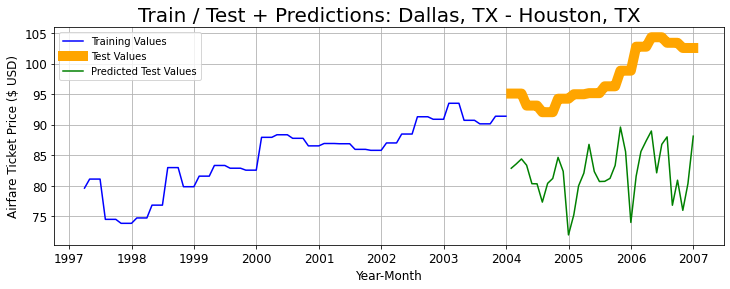

In [34]:
# Testing Function on One Route
result, new_df = model_func(train, unseen)

# Testing On All Routes

Albany, NY - Chicago, IL

                            OLS Regression Results                            
Dep. Variable:                airfare   R-squared:                       0.361
Model:                            OLS   Adj. R-squared:                  0.059
Method:                 Least Squares   F-statistic:                     1.196
Date:                Wed, 07 Oct 2020   Prob (F-statistic):              0.283
Time:                        16:14:43   Log-Likelihood:                -407.51
No. Observations:                  82   AIC:                             869.0
Df Residuals:                      55   BIC:                             934.0
Df Model:                          26                                         
Covariance Type:            nonrobust                                         
                                             coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------

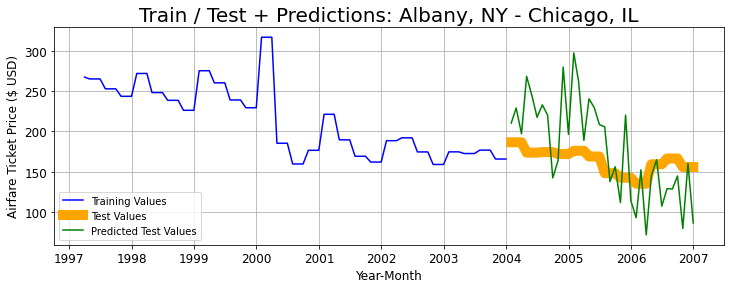

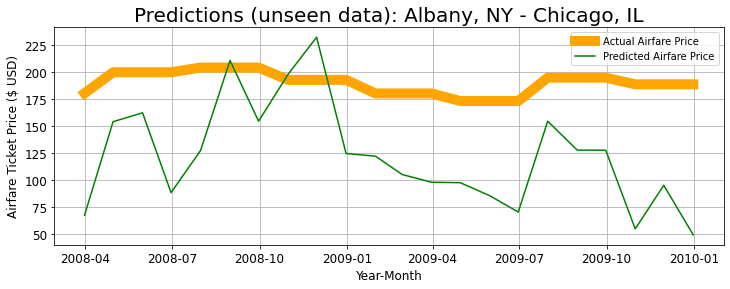

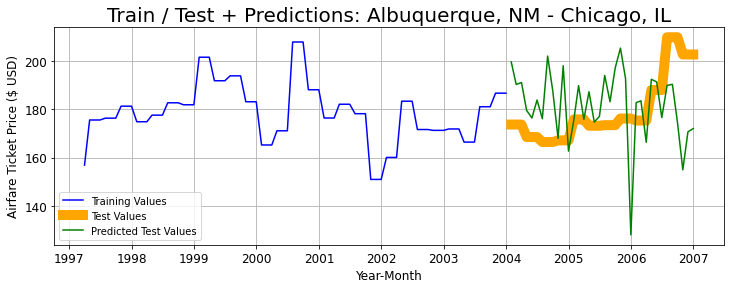

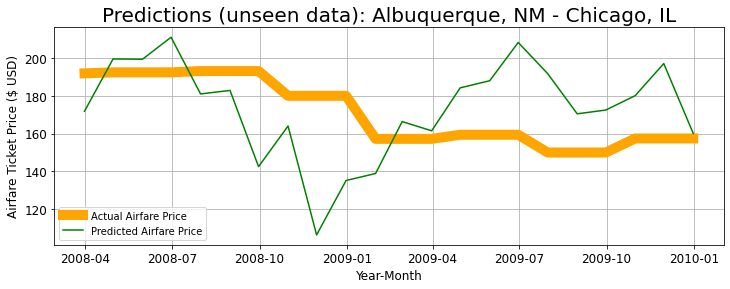

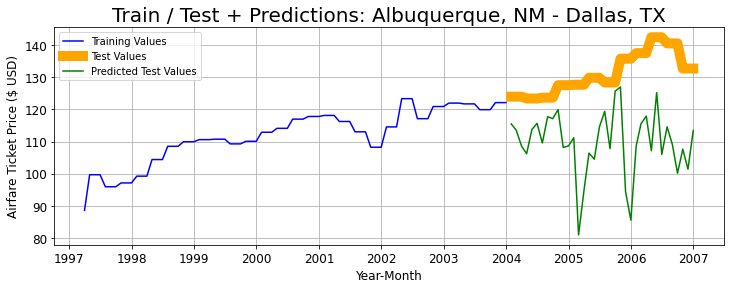

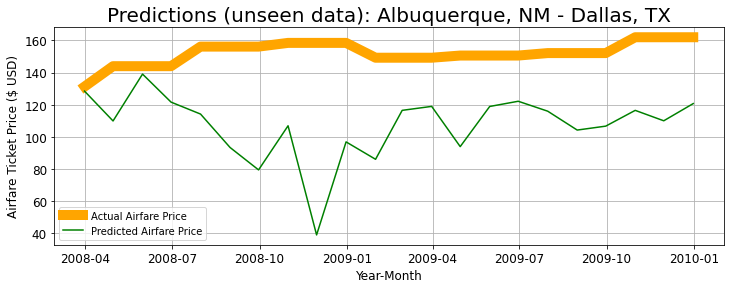

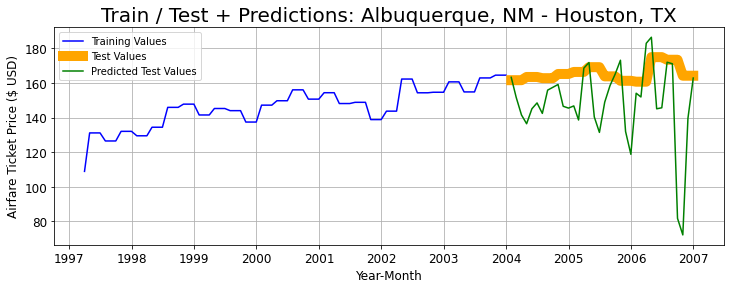

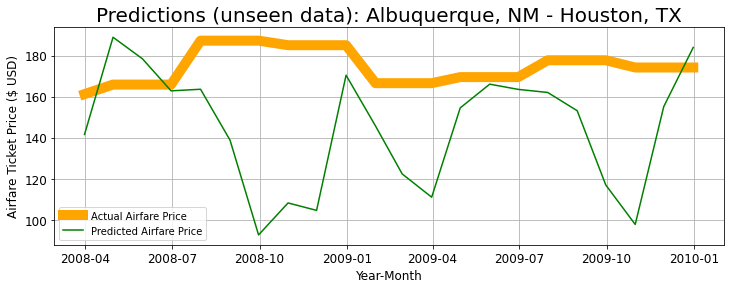

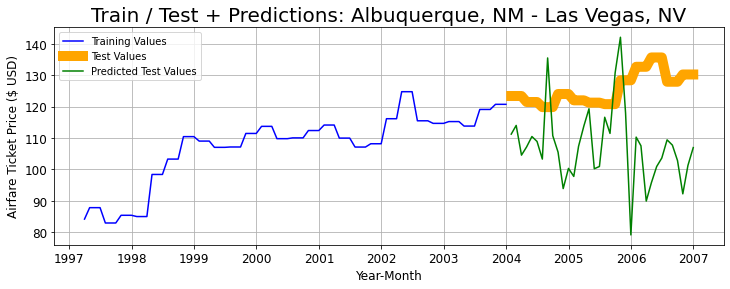

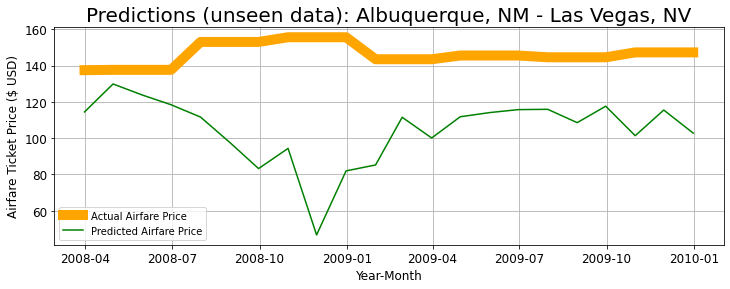

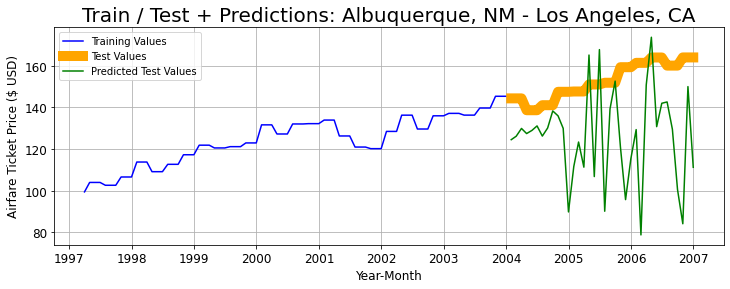

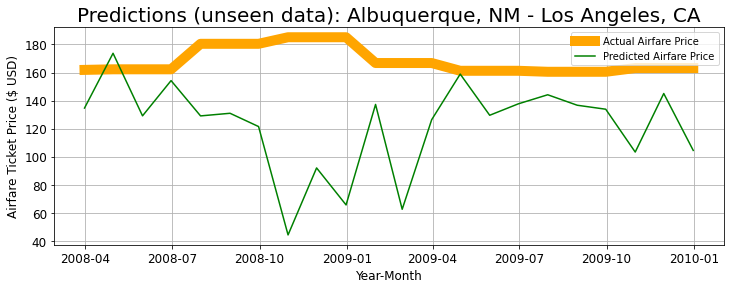

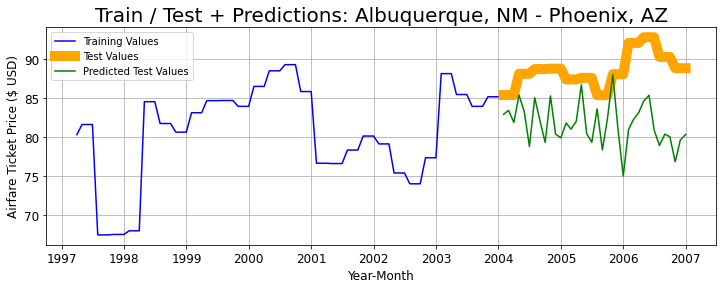

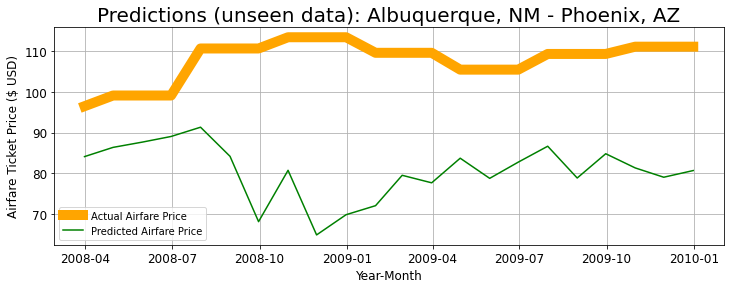

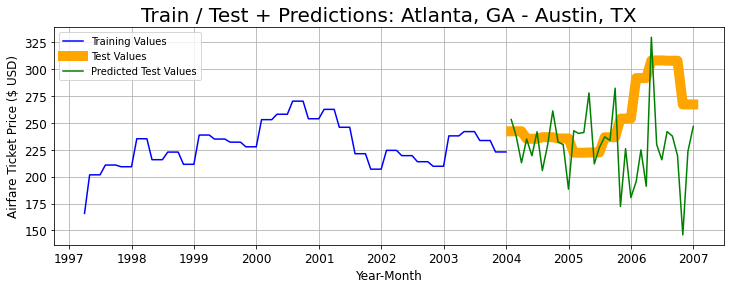

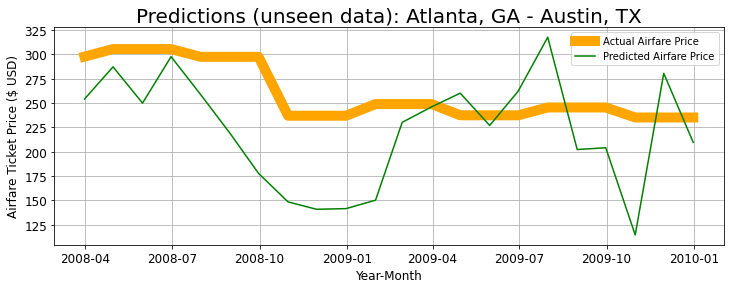

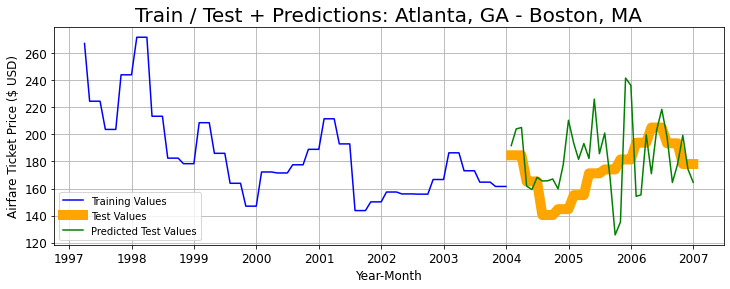

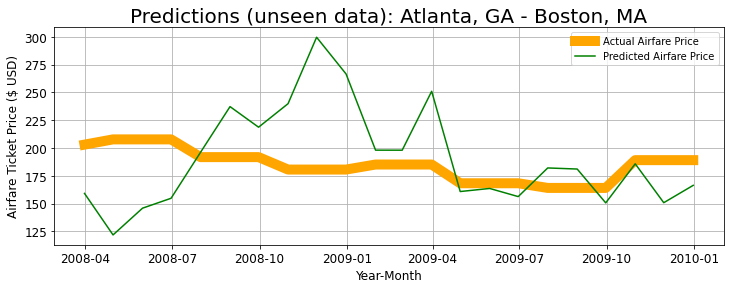

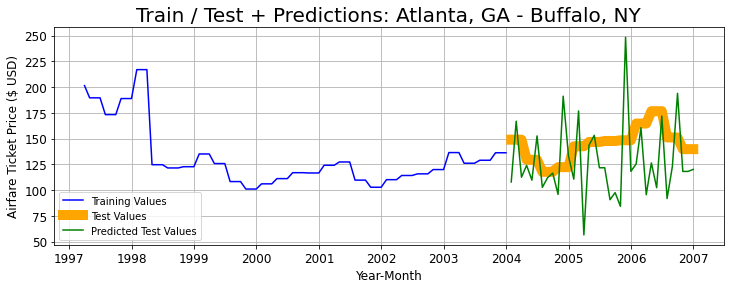

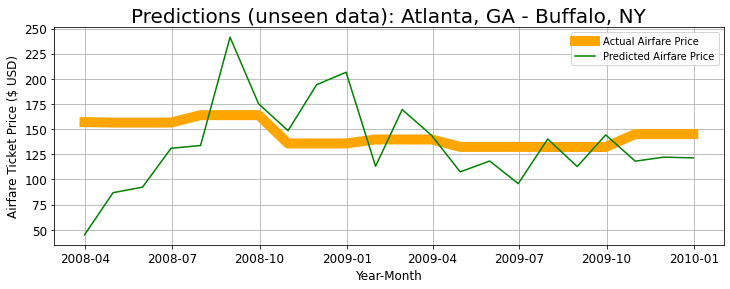

In [19]:
results_df = pd.DataFrame()
for route in train.route.unique()[0:10]: # add this '[0:1]' to end of statement to see only one route
    model, dataframe = model_func(train, unseen, itinerary=route)
    results_df = pd.concat([results_df, dataframe])

In [68]:
results_df = results_df.reset_index()
results_df = results_df.drop(columns='index')
results_df.head()

,index,route,base_r2,train_r2,test_r2,unseen_r2,base_rmse,train_rmse,test_rmse,unseen_rmse
0,0,"Atlanta, GA - Columbus, OH",0.000000e+00,0.999962,0.976911,0.999572,43.920950,0.268043,6.673816,1.546777
1,0,"Atlanta, GA - Dallas, TX",1.110223e-16,1.000000,0.962240,0.996862,17.111730,0.017143,3.325153,0.743976
2,0,"Atlanta, GA - Detroit, MI",-2.220446e-16,0.999842,0.985649,0.982761,9.642247,0.356119,1.155091,1.037787
3,0,"Atlanta, GA - Hartford, CT",2.220446e-16,0.999932,0.999872,0.999892,46.213603,0.389669,0.522444,0.339498
4,0,"Atlanta, GA - Houston, TX",1.110223e-16,0.999993,0.999953,0.999945,17.513918,0.103813,0.120084,0.070058


In [80]:
# Let's look at the analytics
ols_results = results_df.copy()
ols_results.head()

,route,base_r2,train_r2,test_r2,unseen_r2,base_rmse,train_rmse,test_rmse,unseen_rmse
0,"Atlanta, GA - Columbus, OH",0.000000e+00,0.999962,0.976911,0.999572,43.920950,0.268043,6.673816,1.546777
1,"Atlanta, GA - Dallas, TX",1.110223e-16,1.000000,0.962240,0.996862,17.111730,0.017143,3.325153,0.743976
2,"Atlanta, GA - Detroit, MI",-2.220446e-16,0.999842,0.985649,0.982761,9.642247,0.356119,1.155091,1.037787
3,"Atlanta, GA - Hartford, CT",2.220446e-16,0.999932,0.999872,0.999892,46.213603,0.389669,0.522444,0.339498
4,"Atlanta, GA - Houston, TX",1.110223e-16,0.999993,0.999953,0.999945,17.513918,0.103813,0.120084,0.070058


In [86]:
# Let's look closer
ols_results.describe()

,base_r2,train_r2,test_r2,unseen_r2,base_rmse,train_rmse,test_rmse,unseen_rmse,train/test_r2_delta,train/test_r2_%_delta
count,3.750000e+02,375.000000,375.000000,375.000000,375.000000,3.750000e+02,3.750000e+02,3.750000e+02,375.000000,375.000000
mean,-1.154632e-17,0.987888,0.638501,0.695445,17.759035,5.882066e-01,1.441646e+00,1.872379e+00,-0.349388,-0.586968
std,1.072389e-16,0.071913,5.733220,2.370100,12.199136,1.707842e+00,5.575670e+00,7.805169e+00,5.713540,8.606647
min,-4.440892e-16,0.052725,-109.756589,-26.740658,2.352494,5.015767e-12,7.982302e-12,1.530331e-11,-110.429675,-164.064792
25%,0.000000e+00,0.999515,0.995016,0.991477,9.544366,3.050767e-03,6.236859e-02,1.026653e-01,-0.003596,-0.003598
50%,0.000000e+00,0.999981,0.999629,0.999119,14.675491,9.662574e-02,3.085419e-01,3.999790e-01,-0.000190,-0.000190
75%,0.000000e+00,1.000000,0.999986,0.999937,22.066617,4.594632e-01,1.084869e+00,1.136306e+00,-0.000002,-0.000002
max,2.220446e-16,1.000000,1.000000,1.000000,77.635039,1.710228e+01,8.041525e+01,1.226788e+02,0.042186,0.044253


Can R Squared be negative?
Note that it is possible to get a negative R-square for equations that do not contain a constant term. Because R-square is defined as the proportion of variance explained by the fit, if the fit is actually worse than just fitting a horizontal line then R-square is negative.

In [109]:
# r2 analytics - train vs test
ols_results['train/test_r2_delta'] = ols_results['test_r2'] - ols_results['train_r2']
ols_results['train/test_r2_%_delta'] = (ols_results['test_r2'] - ols_results['train_r2']) / ols_results['train_r2']
ols_results['overfit/underfit_r2'] = ['Underfit' if i > 0 else 'Overfit' for i in ols_results['train/test_r2_delta']]

# rmse analytics - train vs test
ols_results['train/test_rmse_delta'] = ols_results['test_rmse'] - ols_results['train_rmse']
ols_results['train/test_rmse_%_delta'] = (ols_results['test_rmse'] - ols_results['train_rmse']) / ols_results['train_rmse']
ols_results['overfit/underfit_rmse'] = ['Underfit' if i > 0 else 'Overfit' for i in ols_results['train/test_rmse_delta']]

# r2 analytics - test vs unseen
ols_results['test/unseen_r2_delta'] = ols_results['unseen_r2'] - ols_results['test_r2']
ols_results['unseen_outperforms_r2'] = ['Outperforms' if i > 0 else 'Underperforms' for i in ols_results['test/unseen_r2_delta']]

# rmse analytics - test vs unseen
ols_results['test/unseen_rmse_delta'] = ols_results['unseen_rmse'] - ols_results['test_rmse']
ols_results['unseen_outperforms_rmse'] = ['Outperforms' if i > 0 else 'Underperforms' for i in ols_results['test/unseen_rmse_delta']]

ols_results.head()

,route,base_r2,train_r2,test_r2,unseen_r2,base_rmse,train_rmse,test_rmse,unseen_rmse,train/test_r2_delta,overfit/underfit,train/test_r2_%_delta,overfit/underfit_r2,train/test_rmse_delta,overfit/underfit_rmse,train/test_rmse_%_delta,test/unseen_r2_delta,unseen_outperforms_r2,test/unseen_rmse_delta,unseen_outperforms_rmse
0,"Atlanta, GA - Columbus, OH",0.000000e+00,0.999962,0.976911,0.999572,43.920950,0.268043,6.673816,1.546777,-0.023051,Overfit,-0.023052,Overfit,6.405773,Underfit,23.898310,0.022661,Outperforms,-5.127039,Underperforms
1,"Atlanta, GA - Dallas, TX",1.110223e-16,1.000000,0.962240,0.996862,17.111730,0.017143,3.325153,0.743976,-0.037760,Overfit,-0.037760,Overfit,3.308010,Underfit,192.964089,0.034623,Outperforms,-2.581177,Underperforms
2,"Atlanta, GA - Detroit, MI",-2.220446e-16,0.999842,0.985649,0.982761,9.642247,0.356119,1.155091,1.037787,-0.014193,Overfit,-0.014195,Overfit,0.798972,Underfit,2.243553,-0.002888,Underperforms,-0.117305,Underperforms
3,"Atlanta, GA - Hartford, CT",2.220446e-16,0.999932,0.999872,0.999892,46.213603,0.389669,0.522444,0.339498,-0.000060,Overfit,-0.000060,Overfit,0.132775,Underfit,0.340737,0.000019,Outperforms,-0.182946,Underperforms
4,"Atlanta, GA - Houston, TX",1.110223e-16,0.999993,0.999953,0.999945,17.513918,0.103813,0.120084,0.070058,-0.000040,Overfit,-0.000040,Overfit,0.016270,Underfit,0.156728,-0.000008,Underperforms,-0.050026,Underperforms


In [110]:
# 93% of our models are underfit - When we take a closer look they are barely underfit for the majority which is great
ols_results['overfit/underfit'].value_counts(normalize=True)

Overfit     0.933333
Underfit    0.066667
Name: overfit/underfit, dtype: float64

In [111]:
ols_results['train/test_r2_%_delta'].sort_values()

299   -164.064792
274    -26.925713
336    -12.568658
193     -4.211388
147     -2.326493
          ...    
260      0.002314
116      0.005048
112      0.010778
17       0.043559
217      0.044253
Name: train/test_r2_%_delta, Length: 375, dtype: float64

In [119]:
# There is a number of routes our model does not play nice with
ols_results[(ols_results['overfit/underfit'] == 'Overfit')].sort_values('train/test_r2_%_delta').head(30)

,route,base_r2,train_r2,test_r2,unseen_r2,base_rmse,train_rmse,test_rmse,unseen_rmse,train/test_r2_delta,overfit/underfit,train/test_r2_%_delta,overfit/underfit_r2,train/test_rmse_delta,overfit/underfit_rmse,train/test_rmse_%_delta,test/unseen_r2_delta,unseen_outperforms_r2,test/unseen_rmse_delta,unseen_outperforms_rmse
299,"New York, NY - Orlando, FL",0.000000e+00,0.673086,-109.756589,-25.692576,7.641061,5.117727e+00,80.415253,27.499544,-110.429675,Overfit,-164.064792,Overfit,75.297526,Underfit,1.471308e+01,84.064013,Outperforms,-52.915709,Underperforms
274,"Miami, FL - Pittsburgh, PA",0.000000e+00,0.052725,-1.366925,-0.192407,11.305041,1.385570e+01,17.392596,11.133965,-1.419650,Overfit,-26.925713,Overfit,3.536895,Underfit,2.552664e-01,1.174518,Outperforms,-6.258630,Underperforms
336,"Portland, OR - Reno, NV",-2.220446e-16,0.533572,-6.172717,-12.178821,5.025840,2.758666e+00,13.460168,38.727452,-6.706290,Overfit,-12.568658,Overfit,10.701503,Underfit,3.879231e+00,-6.006104,Underperforms,25.267284,Outperforms
193,"Hartford, CT - Orlando, FL",0.000000e+00,0.386761,-1.242039,-26.740658,15.654281,1.023468e+01,23.439844,53.736694,-1.628800,Overfit,-4.211388,Overfit,13.205166,Underfit,1.290238e+00,-25.498619,Underperforms,30.296851,Outperforms
147,"Dallas, TX - Minneapolis, MN",2.220446e-16,0.867783,-1.151108,-6.845270,32.653777,1.122532e+01,47.892169,38.953148,-2.018890,Overfit,-2.326493,Overfit,36.666852,Underfit,3.266442e+00,-5.694162,Underperforms,-8.939022,Underperforms
97,"Chicago, IL - Richmond, VA",0.000000e+00,0.759851,-0.952682,0.146145,22.179013,1.710228e+01,30.992597,26.829877,-1.712533,Overfit,-2.253774,Overfit,13.890320,Underfit,8.121913e-01,1.098827,Outperforms,-4.162720,Underperforms
73,"Chicago, IL - Cleveland, OH",2.220446e-16,0.862830,-0.420480,-3.860564,5.515378,3.512576e+00,6.573442,13.842133,-1.283310,Overfit,-1.487326,Overfit,3.060866,Underfit,8.714019e-01,-3.440084,Underperforms,7.268691,Outperforms
347,"Salt Lake City, UT - San Francisco, CA",-2.220446e-16,0.868834,0.036277,-0.718284,10.658013,4.954751e+00,10.462908,12.703459,-0.832558,Overfit,-0.958246,Overfit,5.508156,Underfit,1.111692e+00,-0.754561,Underperforms,2.240551,Outperforms
68,"Charlotte, NC - Philadelphia, PA",0.000000e+00,0.574253,0.204252,-18.628008,29.517241,1.364227e+01,26.330771,122.678808,-0.370001,Overfit,-0.644317,Overfit,12.688500,Underfit,9.300871e-01,-18.832260,Underperforms,96.348037,Outperforms
201,"Houston, TX - Nashville, TN",0.000000e+00,0.988634,0.502593,0.609635,5.919021,1.246676e+00,4.174511,5.267511,-0.486040,Overfit,-0.491628,Overfit,2.927836,Underfit,2.348514e+00,0.107041,Outperforms,1.092999,Outperforms


After taking a close look there is about 25-30 of our overfit models that don't play well

In [127]:
# There is a number of routes our model plays very well with -- selected for 0.20 r2 delta or greater
ols_results[(ols_results['overfit/underfit'] == 'Underfit')].sort_values('train/test_r2_%_delta', ascending=False)

,route,base_r2,train_r2,test_r2,unseen_r2,base_rmse,train_rmse,test_rmse,unseen_rmse,train/test_r2_delta,overfit/underfit,train/test_r2_%_delta,overfit/underfit_r2,train/test_rmse_delta,overfit/underfit_rmse,train/test_rmse_%_delta,test/unseen_r2_delta,unseen_outperforms_r2,test/unseen_rmse_delta,unseen_outperforms_rmse
217,"Indianapolis, IN - Las Vegas, NV",0.000000e+00,0.953278,0.995464,0.976853,21.328214,1.490459,1.436445,2.222666,4.218584e-02,Underfit,4.425344e-02,Underfit,-0.054014,Overfit,-0.036240,-1.861092e-02,Underperforms,7.862214e-01,Outperforms
17,"Atlanta, GA - Philadelphia, PA",0.000000e+00,0.940009,0.980955,0.933083,16.748518,1.905977,2.311384,3.575101,4.094543e-02,Underfit,4.355855e-02,Underfit,0.405406,Underfit,0.212702,-4.787143e-02,Underperforms,1.263717e+00,Outperforms
112,"Cincinnati, OH - Philadelphia, PA",0.000000e+00,0.985484,0.996105,0.997711,51.923245,1.794952,3.240504,3.185385,1.062138e-02,Underfit,1.077783e-02,Underfit,1.445552,Underfit,0.805343,1.606385e-03,Outperforms,-5.511899e-02,Underperforms
116,"Cleveland, OH - Dallas, TX",-2.220446e-16,0.975026,0.979948,0.910395,18.481275,3.513277,2.617046,4.485068,4.921858e-03,Underfit,5.047924e-03,Underfit,-0.896231,Overfit,-0.255098,-6.955264e-02,Underperforms,1.868022e+00,Outperforms
260,"Los Angeles, CA - Salt Lake City, UT",0.000000e+00,0.995676,0.997980,0.991525,11.294782,0.502200,0.507661,0.624616,2.303965e-03,Underfit,2.313971e-03,Underfit,0.005462,Underfit,0.010876,-6.455118e-03,Underperforms,1.169543e-01,Outperforms
130,"Columbus, OH - Orlando, FL",-2.220446e-16,0.984171,0.986333,0.995519,11.263282,1.205830,1.316741,0.809992,2.162303e-03,Underfit,2.197081e-03,Underfit,0.110911,Underfit,0.091979,9.185458e-03,Outperforms,-5.067493e-01,Underperforms
295,"Nashville, TN - Philadelphia, PA",0.000000e+00,0.985351,0.986926,0.366448,37.209933,3.851285,4.254644,5.840785,1.574860e-03,Underfit,1.598272e-03,Underfit,0.403359,Underfit,0.104734,-6.204784e-01,Underperforms,1.586141e+00,Outperforms
165,"Dallas, TX - Tampa, FL",0.000000e+00,0.993098,0.994585,0.988955,21.933263,1.596584,1.614001,1.647360,1.486615e-03,Underfit,1.496947e-03,Underfit,0.017418,Underfit,0.010909,-5.629884e-03,Underperforms,3.335823e-02,Outperforms
216,"Houston, TX - Washington, DC",0.000000e+00,0.997727,0.998709,0.995919,16.987580,0.737617,0.610340,0.913539,9.823625e-04,Underfit,9.846007e-04,Underfit,-0.127277,Overfit,-0.172551,-2.790493e-03,Underperforms,3.031987e-01,Outperforms
195,"Houston, TX - Indianapolis, IN",0.000000e+00,0.995788,0.996560,0.979320,15.487829,0.908090,0.908425,2.219712,7.718354e-04,Underfit,7.751002e-04,Underfit,0.000335,Underfit,0.000369,-1.724008e-02,Underperforms,1.311287e+00,Outperforms


### Let's try another model to see if we can do better with the routes that our model is having difficulty with

In [134]:
from statsmodels.tsa.vector_ar.vecm import VAR

# These 16 routes are the worst performers -  selected
ols_results[(ols_results['overfit/underfit'] == 'Overfit')].sort_values('train/test_r2_%_delta').head(16)
ols_results[(ols_results['overfit/underfit'] == 'Overfit')].sort_values('train/test_r2_%_delta').head(16).route

299                New York, NY - Orlando, FL
274                Miami, FL - Pittsburgh, PA
336                   Portland, OR - Reno, NV
193                Hartford, CT - Orlando, FL
147              Dallas, TX - Minneapolis, MN
97                 Chicago, IL - Richmond, VA
73                Chicago, IL - Cleveland, OH
347    Salt Lake City, UT - San Francisco, CA
68           Charlotte, NC - Philadelphia, PA
201               Houston, TX - Nashville, TN
304              New York, NY - Rochester, NY
341                Portland, OR - Spokane, WA
197               Houston, TX - Las Vegas, NV
176               Detroit, MI - Nashville, TN
187                 El Paso, TX - Houston, TX
225           Jacksonville, FL - New York, NY
Name: route, dtype: object

In [181]:
sorted(train.columns)

['airfare',
 'airfare_lag_1',
 'cost_per_mile',
 'dest_lat',
 'dest_long',
 'dist_miles',
 'flight_demand',
 'flight_demand_lag_1',
 'flight_demand_lag_12',
 'flight_revenue',
 'flight_revenue_lag_12',
 'fuel_usd_pergallon',
 'fuel_usd_pergallon_lag_1',
 'num_of_flights',
 'num_of_flights_lag_12',
 'num_of_flights_lag_2',
 'num_of_flights_lag_3',
 'origin_lat',
 'origin_long',
 'passengers',
 'passengers_lag_1',
 'passengers_lag_12',
 'passengers_per_flight',
 'passengers_per_flight_lag_1',
 'passengers_per_flight_lag_12',
 'pop_dest',
 'pop_origin',
 'route',
 'seat_capacity',
 'seat_capacity_lag_1',
 'seat_capacity_lag_2',
 'sf_airfare_diff_1',
 'sf_airfare_lag_1_diff_1',
 'sf_cost_per_mile_diff_1',
 'sf_flight_demand_diff_1',
 'sf_flight_demand_lag_12_diff_1',
 'sf_flight_demand_lag_1_diff_1',
 'sf_flight_revenue_diff_2',
 'sf_flight_revenue_lag_12_diff_1',
 'sf_fuel_usd_pergallon_diff_1',
 'sf_fuel_usd_pergallon_lag_1_diff_1',
 'sf_num_of_flights_diff_1',
 'sf_num_of_flights_lag_12

In [175]:
final_features

['sf_airfare_diff_1',
 'sf_cost_per_mile_diff_1',
 'sf_fuel_usd_pergallon_diff_1',
 'sf_fuel_usd_pergallon_lag_1_diff_1',
 'sf_num_of_flights_lag_2_diff_1',
 'sf_passengers_lag_1_diff_2',
 'sf_passengers_per_flight_lag_12_diff_2',
 'dist_miles']

In [244]:
test_features = [
 'sf_airfare_diff_1',
 'sf_cost_per_mile_diff_1',
#  'sf_fuel_usd_pergallon_diff_1',
 'sf_num_of_flights_diff_1',
 'sf_passengers_diff_2',
 'sf_passengers_per_flight_diff_2',
 'dist_miles'
]

In [300]:
parameters = ['passengers', 'seat_capacity', 'num_of_flights', 'dist_miles', 'airfare', 'fuel_usd_pergallon', 'total_flight_miles', 
              'total_flight_cost', 'flight_demand', 'cost_per_mile', 'flight_revenue', 'passengers_per_flight']

def read_route(df, itinerary='Dallas, TX - Houston, TX', params=parameters, maxlags_int=15, test_size_float = 0.25, ic_string='aic', trend_string='c'):
    
    df = df[df['route'] == itinerary].copy()
    
    train, test = train_test_split(df[params], test_size = test_size_float, shuffle=False, random_state=1983)
    
    model = VAR(train).fit(maxlags = maxlags_int, ic = ic_string, trend = trend_string)
    
    print(f'What is the order of our autoregressive model: {model.k_ar}')
    print(model.summary())

    return itinerary, model, df, train, test

In [301]:
route_itinerary, var_model, var_df, var_train, var_test = read_route(train, itinerary='New York, NY - Orlando, FL', maxlags_int=1, params=test_features)

What is the order of our autoregressive model: 1
  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 07, Oct, 2020
Time:                     09:19:36
--------------------------------------------------------------------
No. of Equations:         6.00000    BIC:                    17.7864
Nobs:                     98.0000    HQIC:                   17.1267
Log likelihood:          -1609.59    FPE:                1.75411e+07
AIC:                      16.6786    Det(Omega_mle):     1.15952e+07
--------------------------------------------------------------------
Results for equation sf_airfare_diff_1
                                        coefficient       std. error           t-stat            prob
-----------------------------------------------------------------------------------------------------
const                                     -2.613056       657.439683           -0.004           0.997
L1.sf_airfare_dif

/Users/tonylucci/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


New York, NY - Orlando, FL


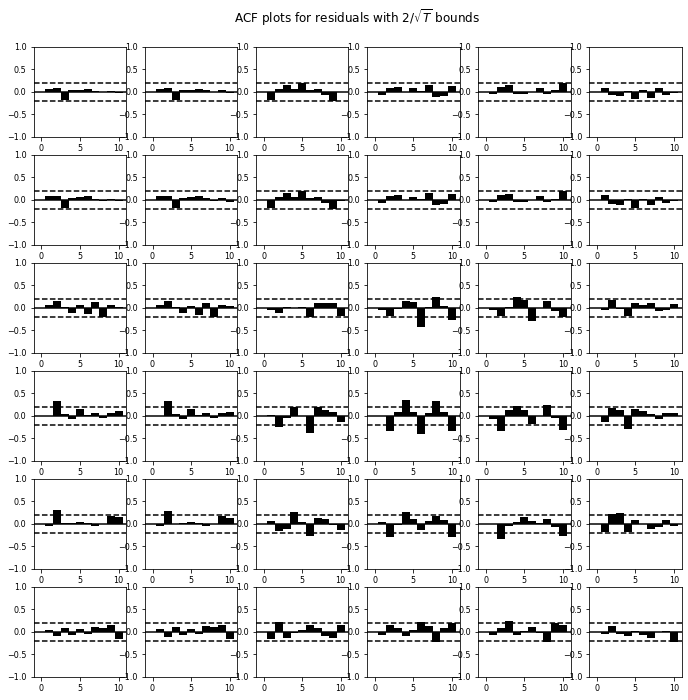

In [271]:
print(route_itinerary)
var_model.plot_acorr();

In [302]:
print(var_df.shape)
print(var_train.shape)
print(var_test.shape)

(132, 58)
(99, 6)
(33, 6)


In [309]:
train[['airfare', 'sf_airfare_diff_1', 'route']][train['route'] == 'Atlanta, GA - Columbus, OH']

,airfare,sf_airfare_diff_1,route
year-month,,,
1996-01-31,103.16,-91.14,"Atlanta, GA - Columbus, OH"
1996-02-29,103.16,-91.14,"Atlanta, GA - Columbus, OH"
1996-03-31,103.16,-91.14,"Atlanta, GA - Columbus, OH"
1996-04-30,117.48,-86.21,"Atlanta, GA - Columbus, OH"
1996-05-31,117.48,-86.21,"Atlanta, GA - Columbus, OH"
...,...,...,...
2006-08-31,275.17,105.18,"Atlanta, GA - Columbus, OH"
2006-09-30,275.17,105.18,"Atlanta, GA - Columbus, OH"
2006-10-31,248.49,98.43,"Atlanta, GA - Columbus, OH"


In [304]:
var_df['airfare'].diff()

year-month
1996-01-31     NaN
1996-02-29    0.00
1996-03-31    0.00
1996-04-30   -9.08
1996-05-31    0.00
              ... 
2006-08-31    0.00
2006-09-30    0.00
2006-10-31    5.77
2006-11-30    0.00
2006-12-31    0.00
Name: airfare, Length: 132, dtype: float64

In [303]:
var_df[['airfare', 'sf_airfare_diff_1']].head()

,airfare,sf_airfare_diff_1
year-month,,
1996-01-31,138.10,-28.53
1996-02-29,138.10,-28.53
1996-03-31,138.10,-28.53
1996-04-30,129.02,-25.97
1996-05-31,129.02,-25.97


In [ ]:
airfare_reverse = []
for amount in var_df['sf_airfare_diff_1']:
    airfare_reverse =

New York, NY - Orlando, FL


''

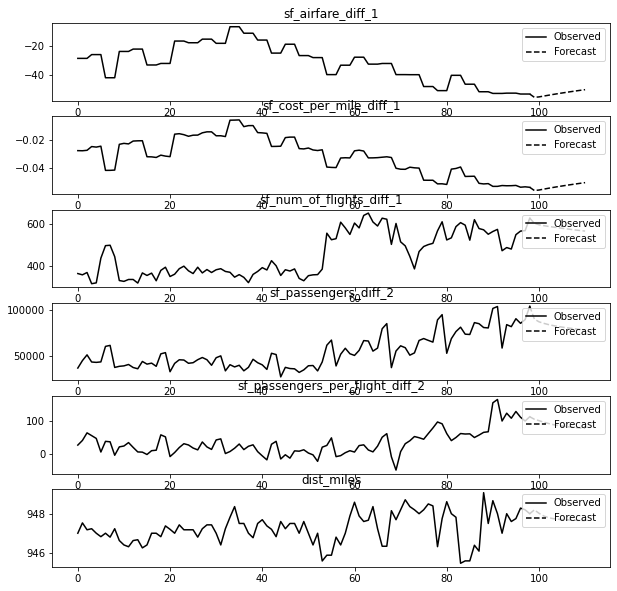

In [290]:
print(route_itinerary)
var_model.plot_forecast(12, plot_stderr=False)
# plt.legend(loc='best')
;

In [298]:
var_train

,sf_airfare_diff_1,sf_cost_per_mile_diff_1,sf_num_of_flights_diff_1,sf_passengers_diff_2,sf_passengers_per_flight_diff_2,dist_miles
year-month,,,,,,
1996-01-31,-28.53,-0.027473,365.0,37396.0,27.684777,947.000000
1996-02-29,-28.53,-0.027555,359.0,45482.0,41.556201,947.529412
1996-03-31,-28.53,-0.027230,370.0,51704.0,64.155249,947.176471
1996-04-30,-25.97,-0.024570,317.0,43957.0,55.910465,947.230769
1996-05-31,-25.97,-0.024955,321.0,43558.0,47.555744,947.000000
...,...,...,...,...,...,...
2003-11-30,-52.06,-0.052444,481.0,82271.0,107.700828,947.600000
2003-12-31,-52.06,-0.052259,549.0,90869.0,127.785709,947.750000
2004-01-31,-52.66,-0.053531,566.0,85876.0,110.677989,948.285714


In [273]:
print(route_itinerary)
var_model.k_ar

New York, NY - Orlando, FL


1

In [274]:
print(route_itinerary)
var_model.forecast(y=var_train.values, steps=3)

New York, NY - Orlando, FL


array([[-5.48943856e+01, -5.58854707e-02,  6.02962994e+02,
         9.04755325e+04,  1.04644991e+02,  9.48195620e+02],
       [-5.46135504e+01, -5.55412747e-02,  5.95942617e+02,
         8.75341780e+04,  1.00489122e+02,  9.48022875e+02],
       [-5.40630560e+01, -5.49215476e-02,  5.91817289e+02,
         8.59011319e+04,  9.61085522e+01,  9.47887180e+02]])

In [276]:
print(route_itinerary)
var_model.forecast(y=var_test.values, steps=3)

New York, NY - Orlando, FL


array([[-4.09733741e+01, -4.07666954e-02,  4.91958668e+02,
         7.03471344e+04,  7.35167506e+01,  9.47349408e+02],
       [-4.14628104e+01, -4.13642672e-02,  4.93245199e+02,
         6.88621783e+04,  6.92612302e+01,  9.47390178e+02],
       [-4.15830839e+01, -4.15381146e-02,  4.95690290e+02,
         6.83506492e+04,  6.61937681e+01,  9.47405880e+02]])

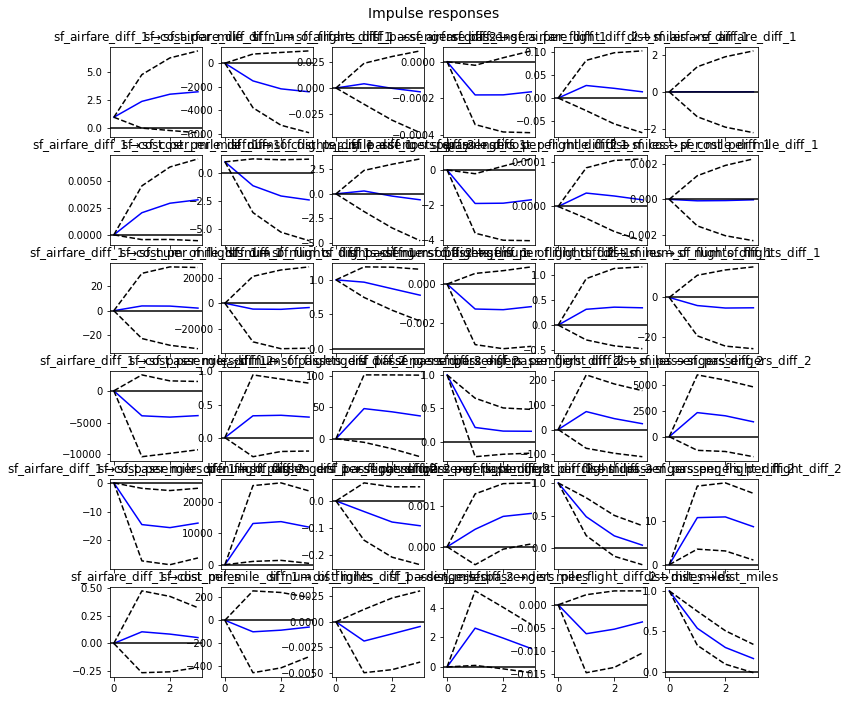

In [280]:
var_model.irf(3).plot(orth=False);

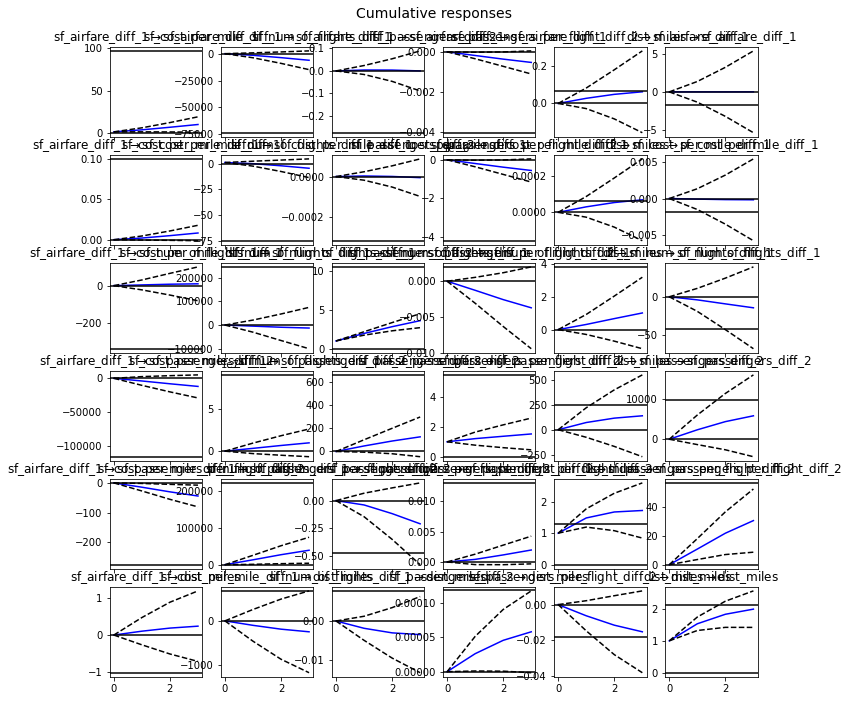

In [281]:
var_model.irf(3).plot_cum_effects(orth=False); # https://notes.quantecon.org/submission/5db25b54831cf4001af7e506